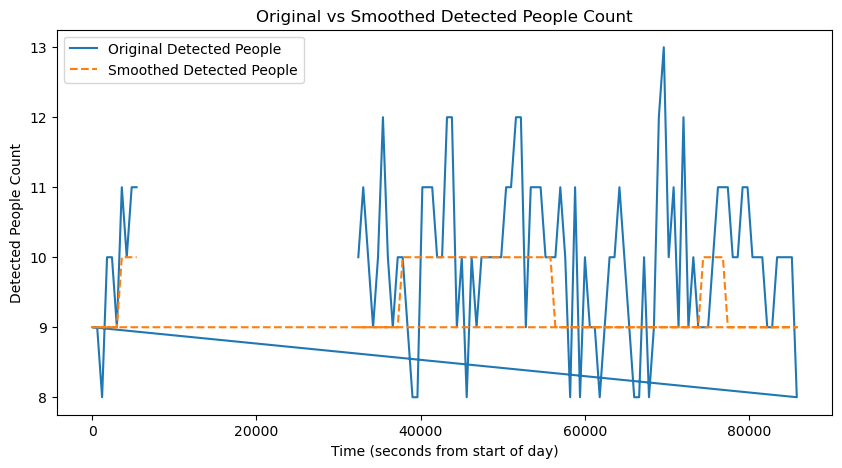

입력 데이터 크기: (2959, 6)
출력 데이터 크기: (2959,)


In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# 1. 데이터 로드
file_path = '/Users/a0000/Desktop/cafe 1 data.csv'
df = pd.read_csv(file_path, encoding='utf-8-sig')
df.columns = ['date', 'time', 'detected_people']  # 컬럼명 설정

# 2. 시간 변환
df['date'] = pd.to_datetime(df['date'])  # 날짜 컬럼을 datetime 형식으로 변환
df['time'] = pd.to_timedelta(df['time']).dt.total_seconds().astype(int)  # 시간 컬럼을 초 단위로 변환

# 3. Gaussian 스무딩 적용
sigma = 10  # 스무딩 강도 설정
df['detected_people_smoothed'] = gaussian_filter1d(df['detected_people'], sigma)

# 4. Min-Max 스케일링
scaler = MinMaxScaler()  # Min-Max 스케일러 생성
df['scaled_detected_people'] = scaler.fit_transform(df[['detected_people_smoothed']])  # 스무딩된 값을 스케일링

# 5. 데이터 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['time'][:100], df['detected_people'][:100], label='Original Detected People')
plt.plot(df['time'][:100], df['detected_people_smoothed'][:100], label='Smoothed Detected People', linestyle='--')
plt.xlabel('Time (seconds from start of day)')
plt.ylabel('Detected People Count')
plt.legend()
plt.title('Original vs Smoothed Detected People Count')
plt.show()

# 학습 데이터 생성
time_window = 6  # 학습에 사용할 시간 창(단위: 10분 간격)
prediction_time = 6  # 예측할 시간 이후의 데이터

# 학습용 입력 데이터와 출력 데이터 생성
x_train, y_train = [], []
for i in range(len(df) - time_window - prediction_time):
    x_train.append(df['scaled_detected_people'].iloc[i:i + time_window].values)
    y_train.append(df['scaled_detected_people'].iloc[i + time_window + prediction_time])

x_train, y_train = np.array(x_train), np.array(y_train)

# 데이터 확인
print("입력 데이터 크기:", x_train.shape)
print("출력 데이터 크기:", y_train.shape)



In [13]:
# 2. 학습 데이터 생성
time_window = 6  # 학습에 사용할 시간 창 (10분 간격 * 6 = 60분)
prediction_time = 6  # 예측할 시간 이후의 데이터 (10분 간격 * 6)

# 학습용 입력 데이터와 출력 데이터 생성
x_train, y_train = [], []
for i in range(len(df) - time_window - prediction_time):
    x_train.append(df['scaled_detected_people'].iloc[i:i + time_window].values)  # 시간 창 내 입력 데이터
    y_train.append(df['scaled_detected_people'].iloc[i + time_window + prediction_time])  # 예측할 값

# NumPy 배열로 변환
x_train, y_train = np.array(x_train), np.array(y_train)

# LSTM 입력 형식에 맞게 데이터 차원 추가 (샘플 수, 타임스텝, 특성 수)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

# 데이터 확인
print(f"x_train 크기: {x_train.shape}")
print(f"y_train 크기: {y_train.shape}")


x_train 크기: (2959, 6, 1)
y_train 크기: (2959,)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 3. LSTM 모델 정의
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),  # 첫 번째 LSTM 레이어
    LSTM(50, return_sequences=False),  # 두 번째 LSTM 레이어
    Dense(1)  # 출력층
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 구조 확인
model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 6, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 4. 모델 학습
model.fit(x_train, y_train, epochs=3, batch_size=10, verbose=1)


Epoch 1/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0237
Epoch 2/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039
Epoch 3/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0042


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


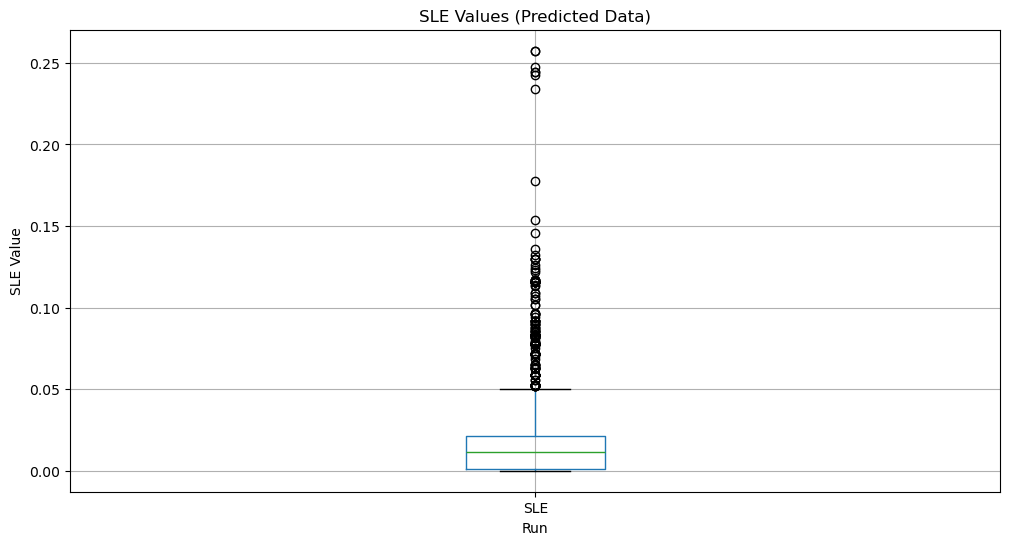

평균 SLE: 0.017501555727984473
중앙값 SLE: 0.011777565516051924
상위 25% SLE: 0.021307878403911275
하위 25% SLE: 0.0011844968865947164
이상치 개수: 191


In [16]:
# 5. 예측 생성
predicted_values = model.predict(x_train)  # 학습 데이터로 예측 수행
predicted_values = scaler.inverse_transform(predicted_values)  # 예측값의 스케일링 복원

# SLE(Squared Log Error) 계산
SLE = np.square(np.log1p(df['detected_people'][-len(predicted_values):].values) - np.log1p(predicted_values.flatten()))

# SLE를 DataFrame으로 저장 및 CSV 파일로 저장
SLE_df = pd.DataFrame({'SLE': SLE})
SLE_df.to_csv('/Users/a0000/Desktop/SLE_values2.csv', index=False)

# SLE 값 시각화 (박스플롯)
plt.figure(figsize=(12, 6))
SLE_df.boxplot()
plt.title("SLE Values (Predicted Data)")
plt.xlabel("Run")
plt.ylabel("SLE Value")
plt.show()

# SLE 통계 계산
Q1 = SLE_df['SLE'].quantile(0.25)
Q3 = SLE_df['SLE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
num_outliers = ((SLE_df['SLE'] < lower_bound) | (SLE_df['SLE'] > upper_bound)).sum()

# 통계 정보를 DataFrame으로 저장
statistics_df = pd.DataFrame({
    'Mean': [SLE_df['SLE'].mean()],
    'Median': [SLE_df['SLE'].median()],
    'Upper 25%': [Q3],
    'Lower 25%': [Q1],
    'Number of Outliers': [num_outliers]
})
statistics_df.to_csv('/Users/a0000/Desktop/SLE_statistics2.csv', index=False)

# 통계 출력
print(f"평균 SLE: {SLE_df['SLE'].mean()}")
print(f"중앙값 SLE: {SLE_df['SLE'].median()}")
print(f"상위 25% SLE: {Q3}")
print(f"하위 25% SLE: {Q1}")
print(f"이상치 개수: {num_outliers}")
